# 15.066 Summer 2025
## System Optimization and Analysis for Operations
### final Project - Group 5A
---
Grayson Adams, Shane Pornprinya, Becca Sholler

---

## Load Packages

In [293]:
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from project_data import *
# %whos

In [294]:
import numpy as np
import os, pathlib
import pandas as pd
FILE_DIR = os.getcwd()

# Fuel Types
FUEL = ['coal', 'NGCC', 'nuclear', 'hydro', 'wind', 'solar', 'ev']

# Carbon Emission in gCO2e per kWh for each fuel type
E = np.array([820, 490, 12, 24, 11.5, 44.5, 0,])

# LCOE in $/kWh for each fuel type from AEO2023
C = np.array([89.33, 42.72, 71.00, 57.12, 31.07, 23.22, 36.27])/1e3

# Number of fuel types
NUMFT = len(E)

# State level data on population, energy demand, current co2 emissions from electricity
FNAME = os.path.join(FILE_DIR, "StateData.xlsx")
STATES = pd.read_excel(FNAME, sheet_name="StateData", index_col=0, header=0)

# EV Capacity (avg) in kWh
EVC_MAX = 80

# Daily EV energy usage in kWh
EVC_MIN = 5*11106/3.5/365 # safety factor * avg annual miles / avg miles/kWh / days per year 

# Population (of the county)
# FNAME = os.path.join(FILE_DIR, "EVs.csv") # TODO fix filename
# EVS = pd.read_csv(FNAME, dtype={'county': str, 'population': float, 'numEV': float})
# EVS['EVB_maxcapacity'] = EVS['numEV'] * EVC_MAX
# EVS['EVB_mincapacity'] = EVS['numEV'] * EVC_MIN

### Approach 1
MAXGEN = [.85, .87, .9, .56, .4, .29, 0] #TODO, Using capacity factor, but does that just represent uptime and we need actual capacity
MINGEN = [0, 0, .25, 0, 0, 0, 0,] #TODO, should be expressed as a minimum kWh number??
# TODO how to account for these going up with EV bank capacity? constrain dec vars for these three + ev bank to their sum, also individual constrs

### Approach 3
HRLYDEMAND = np.array([1, 1, 1, 1, 1, 1,
                       1, 1, 1, 1, 1, 1,
                       1, 1, 1, 1, 1, 1,
                       1, 1, 1, 1, 1, 1,]) # TODO Real data, maybe normalized then multiply by DEMANDPC['<state>']
HRLYMAXGEN = pd.DataFrame() # TODO 7x24 array, 1 and 2 are inf, others need research. Express as pct of demand so it can scale to county
HRLYPRICE = pd.DataFrame() # TODO 7x24 array, most are constant. Units $/kWh

In [295]:
# Set up Gurobi environment
env = gp.Env(empty=True)
env.setParam('OutputFlag', 0)
env.start()

# Initialize the model
m = gp.Model(env=env)

---
## Optimization Case Details

In [296]:
state = 'WA'
futureDemandGrowth = 1.5 # Future electricity demand as pct of current
TotalDemand = STATES['Demand (MWh)'][state]*1e3*futureDemandGrowth # convert to kwh
futureCo2Improve = 0.5 # Future emissions target as pct of current
LimitCO2 = STATES['CO2 Emissions (million metric tons)'][state]*1e12*futureCo2Improve #convert to gCO2e

---
## Decision Variables

In [297]:
### Decision Variables ###

## Continuous
# A vector of qty of each fuel type
F = m.addMVar(NUMFT, vtype=GRB.CONTINUOUS, name='Fuel') # For single day

## Binary
# Whether or not to use each fuel type (due to minimum generation constraints)
X = m.addMVar(NUMFT, vtype=GRB.BINARY, lb=0) 

---
## Objective Function

In [298]:
# Objective function: minimize cost
m.setObjective(gp.quicksum(F[i]*C[i] for i in range(NUMFT)),GRB.MINIMIZE)

---
## Constraints

In [299]:
### Constraints ###
# Total production must meet demand
Const1 = m.addConstr(gp.quicksum(F[i] for i in range(NUMFT))>=TotalDemand, name='Const1')

# Total CO2 emissions must be less than limit
Const2 = m.addConstr(gp.quicksum(F[i]*E[i] for i in range(NUMFT))<=LimitCO2, name='Const2')

# Generation is capacity limited
Const3 = m.addConstrs(F[i] <= MAXGEN[i]*TotalDemand*X[i] for i in range(NUMFT))

# Min generation requirements
Const4 = m.addConstrs(F[i] >= MINGEN[i]*TotalDemand*X[i] for i in range(NUMFT))

---
## Solve

In [300]:
# Update and write the model
m.update() # Update model parameters
m.write("15066_final_project_5A.lp") # Write model to file
m.optimize() # Solve

In [301]:
# Print optimal objective function value
initObjVal = m.getAttr("ObjVal")
print("\nObjective value (total generation cost $):", "%.0f" % (initObjVal))
optCost = initObjVal*100/TotalDemand
print("\nOptimized avg retail price (cents/kWh):", "%.2f" % (optCost))
currCost = STATES['Average retail price (cents/kWh)'][state]
print("\nCurrent per capita generation cost (cents/kWh):", "%.2f" % (currCost))



Objective value (total generation cost $): 4864531023

Optimized avg retail price (cents/kWh): 3.62

Current per capita generation cost (cents/kWh): 10.26


In [302]:
# Print the optimal decision variable solutions
d = {'MWh Generated': (F.getAttr('x')/1e3).round(0),
     'Binding?': (TotalDemand*np.array(MAXGEN)==F.getAttr('x'))}
initSoln = pd.DataFrame(data=d, index=FUEL)
display(initSoln)


,MWh Generated,Binding?
coal,0.0,False
NGCC,6114087.0,False
nuclear,0.0,False
hydro,35527886.0,False
wind,53731578.0,True
solar,38955394.0,True
ev,0.0,True


---
## Review Constraints

In [305]:
# Calculate used budget
# leftoverBudget = m.getConstrByName('Const5').Slack

---
## Senstivity Analysis

[2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525, 2.765525,

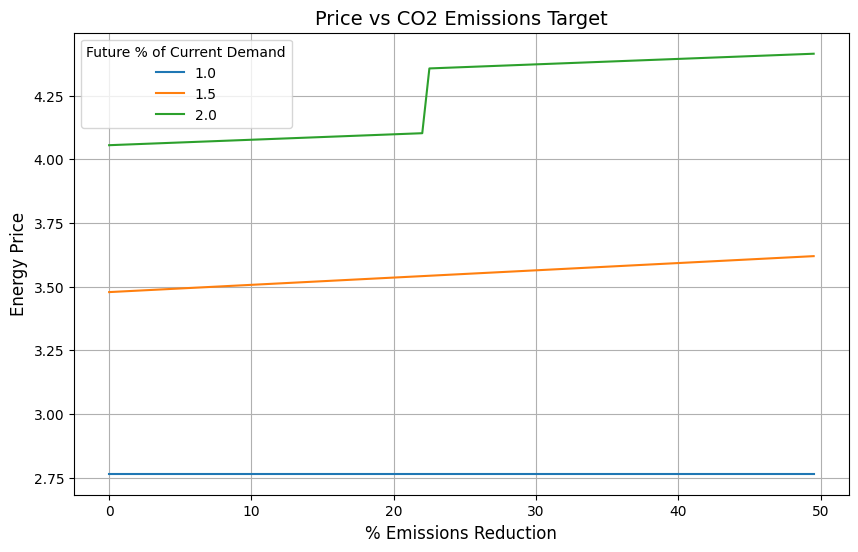

In [ ]:
# newTotalBudget = TotalBudget*1.1
# # Hint: You can change the value of the total budget with this command, by changing the right
# # hand side of Constraint 5, be sure constraint 5 is named 'Const5'
# m.getConstrByName('Const5').setAttr('RHS', newTotalBudget)

# # Re-solve
# m.update()
# m.optimize()

# # Print optimal objective function value
# newObjVal = m.getAttr("ObjVal")
# print(f"New Co2 Emissions Objective value: ","%.0f" %  newObjVal)
# print(f"Pct Change in Objective value: ","%.1f" % ((newObjVal-initObjVal)/initObjVal*100))

# newSoln = pd.DataFrame(SCM.getAttr('x'), index=ODM_names, columns=transport_names)
# print("Change from Initial Solution")
# display(newSoln-initSoln)

# # sensitivity table 
state = 'WA'
futureDemandGrowth = np.arange(1, 2+0.1, .5) # Future electricity demand as pct of current
futureCo2Improve = np.arange(1, 0.5, -0.005) # Future emissions target as pct of current

# # We will create a vector of emissions by looping through budget_sensitivity
price = []
for demand in futureDemandGrowth:
    TotalDemand = STATES['Demand (MWh)'][state]*1e3*demand
    m.getConstrByName('Const1').setAttr('RHS', TotalDemand)
    for emission in futureCo2Improve:
        LimitCO2 = STATES['CO2 Emissions (million metric tons)'][state]*1e12*emission
        m.getConstrByName('Const2').setAttr('RHS', LimitCO2)
        m.update()
        m.optimize()
        price.append(m.getAttr("ObjVal")*100/TotalDemand)
    
# Graph results
plt.figure(figsize=(10, 6))
for i in range(len(futureDemandGrowth)):
    plt.plot([((1-x) * 100) for x in futureCo2Improve],
             price[i*len(futureCo2Improve):(i+1)*len(futureCo2Improve)])
plt.title('Price vs CO2 Emissions Target', fontsize=14)
plt.xlabel('% Emissions Reduction', fontsize=12)
plt.ylabel('Energy Price', fontsize=12)
plt.legend(futureDemandGrowth, title='Future % of Current Demand')
plt.grid(True)
plt.show()